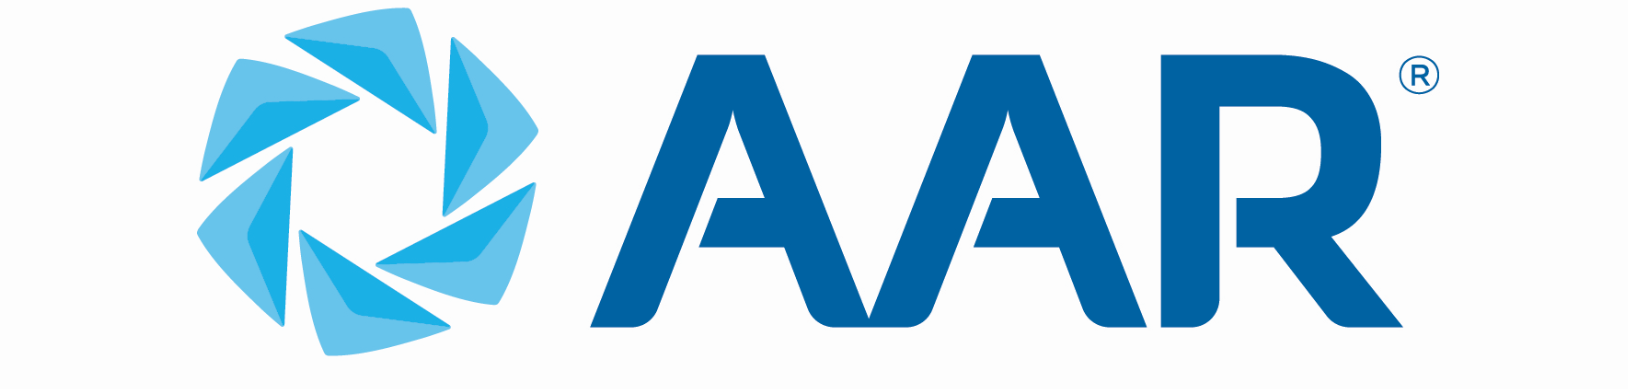



<Center>By: Jeff Tackes</Center>
    
<Center>Director of Analytics</Center>

 # <center> FAA / EASA Shop CERTIFICATION Classifier </center>


# PART 1:  INTRODUCTION

#### Background
An FAA/EASA Cert is essential before we can ship a part to a customer or airline and subsequently install that part on to an aircraft.  Part of the QC process is that upon receipt, these documents are supposed to be scanned in to the system and tagged with the appropriate document type. Occasionally, there are shortfalls in the system and these documents are either not scanned, mislabeled, or not labeled at all.  Currently this misstep in the process is not identified until we are preparing the part for shipment to the customer.  Once this missing document is identified, it then requires the team to scramble to try and find the doc, and in the worst cases, require us to go back to the repair vendor for a copy which may lead to us miss our shipment, resulting in penalties and aircraft groundings.


#### Purpose of Project
The purpose of this project is to be proactive in the process and identify before an active requirement occurs. The goal is to build an image classifer to identify a CERT from a NON-CERT.  


### Load Libraries

In [80]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import glob
import numpy as np
from numpy import expand_dims

import cv2
import os
from os import listdir

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from PyPDF2 import PdfFileWriter, PdfFileReader  # Use for opening and spliting PDFs
from pdf2image import convert_from_path # poppler is required ## conda install -c conda-forge poppler
from PIL import Image


import keras
#from tensorflow.keras import Sequential
#from keras.layers import Conv2D, Flatten, Dense
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D,Activation
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import InputLayer

from sklearn.metrics import classification_report,confusion_matrix
import sklearn.metrics as metrics

#import tensorflow as tf

import seaborn as sns

from io import StringIO
import struct

import time


# PART 2:  BUILD DATASET

## Create dataset by preparing the unprocessed data

Sometime the documents are all scanned as one large, multi page PDF file with no tags.  Since starting this project we did not have a good dataset ready to use, we will need to create one.  

To Create the dataset:
1) Gather a few hundred paperwork samples from the system

2) Split the paperwork to ensure each document is only 1 page.

3) Convert any PDFs to images

4) Identify the document and manually classifify them in a CERT or NONCERT folder



In [48]:
#directory = r'C:\Users\jeffrey.tackes\OneDrive\Code\AAR_Cert_Classifier' # work
directory = r'C:\Users\tacke\OneDrive\Code\AAR_Cert_Classifier' # Home

In [6]:
ext = ['pdf']

pdf_list = []

[pdf_list.extend(glob.glob(directory + r'\UNPROCESSED_DATA\*.' + e)) for e in ext]

[None]

Full file path for the full PDF files.

In [7]:
pdf_list[:5]

['C:\\Users\\tacke\\OneDrive\\Code\\AAR_Cert_Classifier\\UNPROCESSED_DATA\\00001_00003_RMR AVIATION HOLDINGS SN AAB3001451_.pdf',
 'C:\\Users\\tacke\\OneDrive\\Code\\AAR_Cert_Classifier\\UNPROCESSED_DATA\\00001_ADIRU - cert.pdf',
 'C:\\Users\\tacke\\OneDrive\\Code\\AAR_Cert_Classifier\\UNPROCESSED_DATA\\00001_ADIRU.pdf',
 'C:\\Users\\tacke\\OneDrive\\Code\\AAR_Cert_Classifier\\UNPROCESSED_DATA\\00001_CI651099292260_021574280300187.pdf',
 'C:\\Users\\tacke\\OneDrive\\Code\\AAR_Cert_Classifier\\UNPROCESSED_DATA\\00001_CI651099293120_021578129243026.pdf']

The below definitions split PDFs to a single page and then converts them to a JPG.

In [109]:
def seperate_pdf(file_path):
    ext = ['pdf']
    pdf_list = []
    
    [pdf_list.extend(glob.glob(file_path + '\*.' + e)) for e in ext]
    os.mkdir(os.path.join(file_path, 'SinglePagePDF'))
    os.chdir(os.path.join(file_path, 'SinglePagePDF'))
             
    for file in pdf_list:
        inputpdf = PdfFileReader(open(file, "rb"))

        for i in range(inputpdf.numPages):
            output = PdfFileWriter()
            output.addPage(inputpdf.getPage(i))
            
            with open(os.path.basename(file) + "%s.pdf" % i , "wb") as outputStream:
                output.write(outputStream)

    
    
def convert_to_jpg(folder):
    ext = ['pdf']
    pdf_list2 = []
    [pdf_list2.extend(glob.glob( r'*.' + e)) for e in ext]
    
    for file in pdf_list2:
        pages = convert_from_path(file, 500)
        for page in pages:
            page.save(os.path.basename(file) + ".jpg" , 'JPEG') 
    
def prepare_images(image_folder):
    seperate_pdf(file_path)
    #time.sleep(10)
    convert_to_jpg(image_folder)

In [110]:
os.chdir(r'C:\Users\jeffrey.tackes\OneDrive\Code\AAR_Cert_Classifier')
os.getcwd()
#pdf_list2

'C:\\Users\\jeffrey.tackes\\OneDrive\\Code\\AAR_Cert_Classifier'

In [111]:
#seperate_pdf(r'C:\Users\jeffrey.tackes\Desktop\AdditionalTestData')
prepare_images(r'C:\Users\jeffrey.tackes\Desktop\AdditionalTestData','JPG_files')

List of single Page PDF files.

# Manual Review of Documents

At this point, once all the pages are images, I manually review the images to identify them in to the appropriate category.
1) CERTS

2) NONCERTS

The images are seperated in to their respective folders.
We now have a datasets of at least 100 sample images per class and can begin exploration with our classifier.

# PART 3: EDA & Data Augmentation

### Data Augmentation & Image Generators

Below I use the built in image generators in Keras to load the images from the Training and test directories.  Image generators have many benefits:
1) Easy to setup <br>
2) Ability to quickly resize the image on load <br>
3) Great for large datasets to load/train the data in batches. <br>
4) Data Augmentation

My training set only has about 230 images split roughly 50-50 between CERTS and NONCERTS.  While this is a good start, the power of a CNN is when we have large amounts of data. To continue to improve model performance, we want to continue to grow our dataset.  We can do this in 2 ways:
1) Continue to manually create new data and add to the training set <br>
2) Use Keras' data augumentation to create new samples from our current image set.

For this model, I will use (2) to generate new training data.  

My training data generator will apply a series of adjustments to the existing training data:
* shear_range - Adds a bit of distortion to the train images.
* zoom_range - I applied a 0.2 zoom range to allow for variance in images that may have been taken at different distances/resolutions.
* horizontal_flip - I set this to true since these scanned images can be flipped upside down.
* rotation_range - For this I chose a value of 180 which applies a full 360 degree rotation from [-180,180]. I applied the full rotation range since many of our image are scanned and very often come with rotations, and could be completely flipped at any angle.
* brightness_range - Added some adjustments to account for the various scanning quality.
* width_shift_range - Added some shift left - right
* height_shift_range - Added some shift up - down

I will also use this data generator to normalize my inputs.  Easiest way is to divide by 255 to bring all my values between 0 and 1.

In [164]:
TRAIN_PATH = r'.\DATA\TRAIN'
VALID_PATH = r'.\DATA\VALID'
TEST_PATH = r'.\DATA\TEST'


#TRAIN_PATH = r'C:\Users\jeffrey.tackes\OneDrive\Code\AAR_Cert_Classifier\DATA\TRAIN'
#VALID_PATH = r'C:\Users\jeffrey.tackes\OneDrive\Code\AAR_Cert_Classifier\DATA\VALID'
#TEST_PATH = r'C:\Users\jeffrey.tackes\OneDrive\Code\AAR_Cert_Classifier\DATA\TEST'

### Visualize the raw images

In [165]:
ext = ['jpg']

jpg_list = []

[jpg_list.extend(glob.glob(TRAIN_PATH + '\CERTS\*.' + e)) for e in ext]

[jpg_list.extend(glob.glob(TRAIN_PATH + r'\NONCERTS\*.' + e)) for e in ext]



[None]

<Figure size 432x288 with 0 Axes>

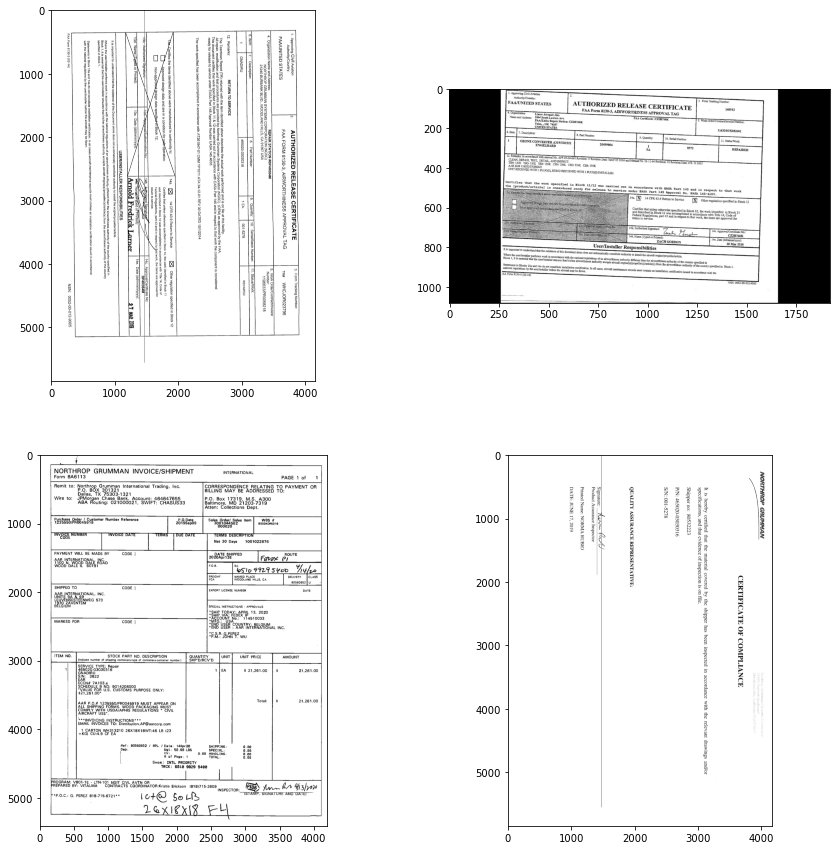

In [154]:
plt.figure()
f, ax = plt.subplots(2,2, figsize = (15,15)) 

pil_im1 = Image.open(jpg_list[2], 'r')
pil_im2 = Image.open(jpg_list[50], 'r')
pil_im3 = Image.open(jpg_list[125], 'r')
pil_im4 = Image.open(jpg_list[150], 'r')

ax[0,0].imshow(pil_im1)
ax[0,1].imshow(pil_im2)
ax[1,0].imshow(pil_im3)
ax[1,1].imshow(pil_im4)

plt.show()

In [172]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            return
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                return
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                    
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                return
        else:
            return
        return width, height

In [167]:
def get_filesize(file):
    file_size = os.stat(file).st_size/1000000
    return file_size

In [180]:
#get_image_size(r'C:\Users\jeffrey.tackes\OneDrive\Code\AAR_Cert_Classifier\DATA\TRAIN\CERTS\00001_image0011.pdf0.pdf4.jpg')
get_image_size(r'.\DATA\TRAIN\CERTS\00001_image0011.pdf0.pdf4.jpg')

(5517, 4221)

In [169]:
print(os.stat(r'C:\Users\jeffrey.tackes\OneDrive\Code\AAR_Cert_Classifier\DATA\TRAIN\CERTS\00001_image0011.pdf0.pdf4.jpg').st_size/1000000,"MB")

1.524047 MB


### View All training Image Sizes

In [182]:
os.getcwd()

'C:\\Users\\jeffrey.tackes\\OneDrive\\Code\\AAR_Cert_Classifier'

In [184]:
labels = ['CERTS', 'NONCERTS']


data = pd.DataFrame([])


for label in labels: 
    path = os.path.join(r'.\Data\Train', label)
    
    class_num = labels.index(label)
    
    for img in os.listdir(path):
        os.path.join(path, img)
        width, height = get_image_size(os.path.join(path, img))
        file_size = get_filesize(os.path.join(path, img))
        x = DataFrame(columns = ['Width','Height','Label',"File_Size"], data = [[width, height, label,file_size]])
        data = data.append(x)
        #print(width, height)


In [185]:
data.head()

,Width,Height,Label,File_Size
0,5517,4221,CERTS,1.524047
0,4267,7000,CERTS,1.740514
0,4267,7000,CERTS,2.307717
0,5848,4130,CERTS,1.271061
0,5848,4128,CERTS,1.314132


### Summary statistics of the images Widths and Heights

In [18]:
data.groupby('Label').describe().unstack(1)

                  Label   
Width      count  CERTS        113.000000
                  NONCERTS     134.000000
           mean   CERTS       2014.893805
                  NONCERTS    4141.388060
           std    CERTS        614.668397
                  NONCERTS     644.888286
           min    CERTS       1366.000000
                  NONCERTS     511.000000
           25%    CERTS       1920.000000
                  NONCERTS    4135.000000
           50%    CERTS       1920.000000
                  NONCERTS    4216.000000
           75%    CERTS       1920.000000
                  NONCERTS    4250.000000
           max    CERTS       5517.000000
                  NONCERTS    5520.000000
Height     count  CERTS        113.000000
                  NONCERTS     134.000000
           mean   CERTS       1240.123894
                  NONCERTS    5371.843284
           std    CERTS        844.773957
                  NONCERTS     844.047061
           min    CERTS        768.000000
       

### Scatterplot of the Training image Width & Heights

<AxesSubplot:xlabel='Width', ylabel='Height'>

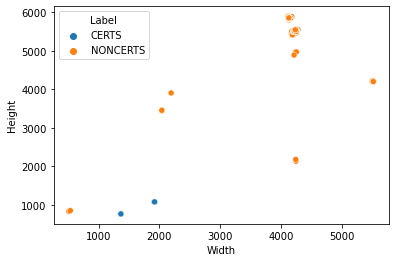

In [73]:
sns.scatterplot(x='Width', y='Height', data=data, hue="Label")

### Histograms of training images Widths and Heights

C:\Users\jeffrey.tackes\Documents\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\jeffrey.tackes\Documents\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


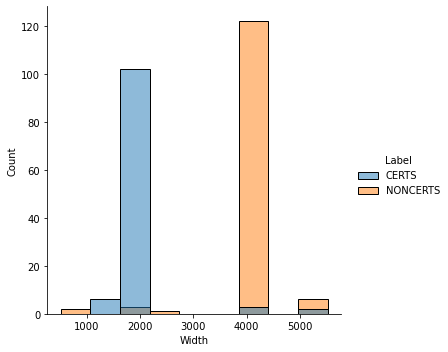

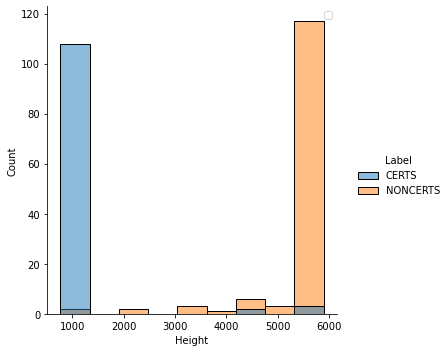

In [117]:
#fig, (ax1, ax2) = plt.subplots(ncols=2)

sns.displot(x='Width',hue='Label', data = data, ax = ax1)

sns.displot(x='Height',hue='Label', data = data, ax = ax2)

plt.legend()

Text(0.5, 6.79999999999999, 'File Size in MB')

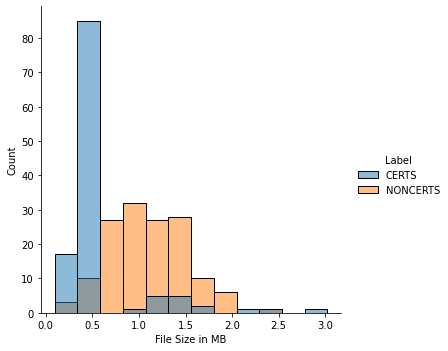

In [187]:
sns.displot(x='File_Size',hue='Label', data = data)
plt.xlabel('File Size in MB')

### Boxplot of Training Images Widghts and Heights

<AxesSubplot:xlabel='Label', ylabel='Height'>

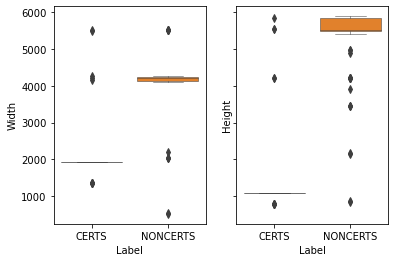

In [103]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.boxplot(x='Label', y='Width' , data = data, linewidth=.5, ax = ax1)
sns.boxplot(x='Label', y='Height' , data = data, linewidth=.5, ax = ax2)


<AxesSubplot:xlabel='File_Size'>

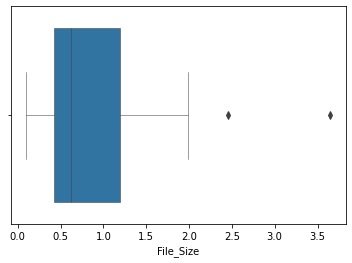

In [22]:
sns.boxplot(x='File_Size' , data = data, linewidth=.5)

In [ ]:
data.

In [115]:
nb_train_samples = 224
nb_validation_samples = 30
batch_size = 32
img_width = 400
img_height = 400

### Build Data Generators

In [136]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    brightness_range=[0.5,1.5],
    width_shift_range=0.05, 
    height_shift_range=0.05)

# this is the augmentation configuration we will use for testing:
# only rescaling

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [137]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode = 'grayscale',
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode = 'grayscale',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(TEST_PATH,
    target_size=(img_width, img_height),
    batch_size=1,
    color_mode = 'grayscale',
    class_mode='categorical',
    shuffle = False) # Shuffle = False otherwise every run will produce different results and hard to evaluate

Found 263 images belonging to 2 classes.
Found 116 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


In [30]:
sample_img = load_img(r'.\DATA\TRAIN\CERTS\00001_image0011.pdf0.pdf4.jpg')
data = img_to_array(sample_img)
samples = expand_dims(data, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


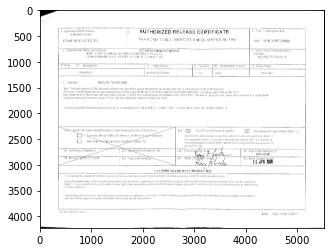

In [31]:
plt.imshow(data)

In [58]:
it = train_datagen.flow(samples, batch_size=1)

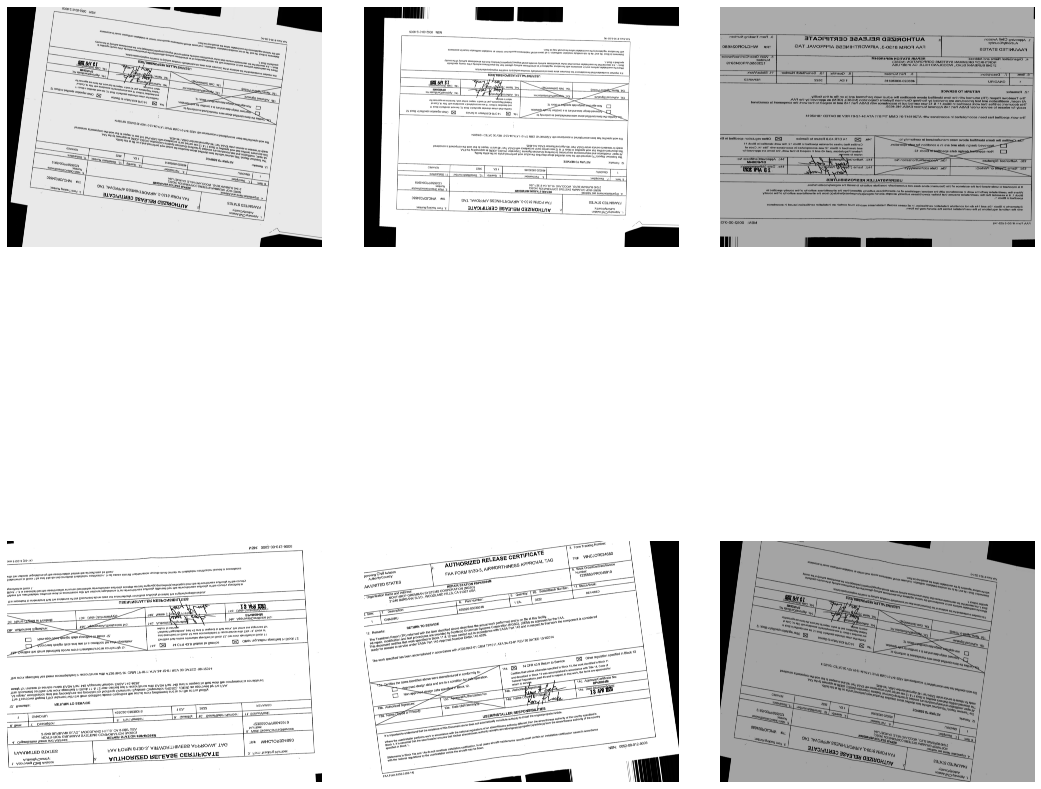

In [59]:
# generate samples and plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
ax = ax.ravel()
fig.tight_layout()

# generate batch of images
for i in range(6):

    # convert to unsigned integers
    image = next(it)[0]
    
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

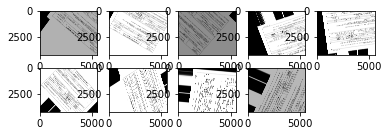

In [51]:
for i in range(9):
    # define subplot
    plt.figsize=(350,350)
    plt.subplot(450 + 1 + i, )
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0] #.astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
plt.show()


# PART 4: BUILDING THE MODEL

The above section shows how the raw data was prepped and organized.  This section will take the raw image data and train a classifer model to identify a CERT from a NONCERT.


Set Variables

In [131]:
epochs = 10


In [121]:
if K.image_data_format() == 'channels_first':
    input_shape = (2, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)


### Build Model

In [142]:
K.clear_session()

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

# Could use loss of categorical_crossentropy with a softmax output layer activation, #
#which is common when there are more than 2 classes, but it works well also with 2 and \
#good to be able to generalize models.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 398, 398, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 197, 197, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        1

In [133]:
batch_size

32

### Train the Model

In [143]:
# notice that we only need to call the x=train_generator, and not the target class value
# Reason is the class data is contained within the generator itself.
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=1)

model.save_weights('10_epochs_more_data_01lr.h5')

Epoch 1/10
7/7 [==============================] - 68s 11s/step - loss: 27.2717 - accuracy: 0.5228 - val_loss: 0.7100 - val_accuracy: 0.4062
Epoch 2/10
7/7 [==============================] - 71s 10s/step - loss: 0.6884 - accuracy: 0.5722 - val_loss: 0.6661 - val_accuracy: 0.8438
Epoch 3/10
7/7 [==============================] - 68s 10s/step - loss: 0.5715 - accuracy: 0.8688 - val_loss: 0.6632 - val_accuracy: 0.3750
Epoch 4/10
7/7 [==============================] - 63s 9s/step - loss: 0.5111 - accuracy: 0.7840 - val_loss: 0.5442 - val_accuracy: 0.7188
Epoch 5/10
7/7 [==============================] - 62s 9s/step - loss: 0.3779 - accuracy: 0.9108 - val_loss: 0.5824 - val_accuracy: 0.6875
Epoch 6/10
7/7 [==============================] - 63s 9s/step - loss: 0.3610 - accuracy: 0.9049 - val_loss: 0.5588 - val_accuracy: 0.7188
Epoch 7/10
7/7 [==============================] - 62s 9s/step - loss: 0.3338 - accuracy: 0.9288 - val_loss: 0.5774 - val_accuracy: 0.6875
Epoch 8/10
7/7 [==============

Below eval is using a 0.01 Learning Rate

In [144]:
model.evaluate(validation_generator)

4/4 [==============================] - 27s 6s/step - loss: 0.4855 - accuracy: 0.7931


[0.4855000078678131, 0.7931034564971924]

Below eval is using a 0.001 Learning Rate

In [140]:
model.evaluate(validation_generator)

4/4 [==============================] - 27s 6s/step - loss: 0.5331 - accuracy: 0.7845


[0.5330589413642883, 0.7844827771186829]

In [108]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

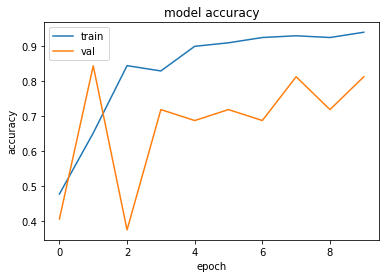

In [145]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

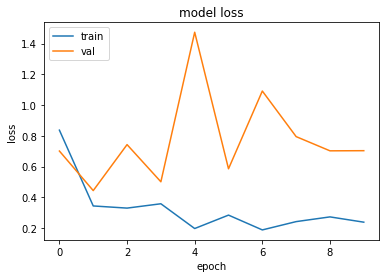

In [127]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### View Labels
In our model, a 0 represents a CERT, and a 1 represents NONCERTS

In [10]:
label_map = (train_generator.class_indices)
label_map

{'CERTS': 0, 'NONCERTS': 1}

# PART 5: PREDICT CLASS ON TEST DATA

Now I will run my trained model on our test data.  The test data is brand new data that the model has not yet seen.  It consists of 20 images, 10 CERTS and 10 NONCERTS.  I will document both my predicted values as well as the true class values to compare the results later.


In [11]:
# Load Weights of last trained model
#model.load_weights(r'first_try.h5')
#model.load_weights(r'10_epochs_more_data.h5')
model.load_weights(r'10_epochs_more_data_01lr.h5')


In [146]:
test_generator.reset()
y_prob = model.predict_generator(test_generator)
true_classes = test_generator.classes

y_class = np.argmax(y_prob,axis=1)


In [147]:
predicted_class = np.argmax(y_prob,axis=1)
filenames = test_generator.filenames
finaldf = pd.DataFrame({'Filename': filenames,'Prediction': predicted_class, 'True Class':true_classes})

### Show Filenames that were improperly classified

45 Images were improperly classified out of the nearly 250 test images.

In [154]:
finaldf[finaldf.Prediction != finaldf['True Class']]

,Filename,Prediction,True Class
0,CERTS\00001_IMOPS13539.pdf0.pdf.jpg,1,0
1,CERTS\00001_Tag.pdf0.pdf.jpg,1,0
2,CERTS\00001_Tags12172020_01.pdf0.pdf.jpg,1,0
3,CERTS\00001_Tags3255.pdf0.pdf.jpg,1,0
4,CERTS\00001_Tags5596.pdf0.pdf.jpg,1,0
5,CERTS\00001_Tags9521.pdf0.pdf.jpg,1,0
6,CERTS\00001_image21327.pdf0.pdf.jpg,1,0
7,CERTS\00001_image229185.pdf0.pdf.jpg,1,0
8,CERTS\00001_image236545.pdf0.pdf.jpg,1,0
9,CERTS\00001_image36439.pdf0.pdf.jpg,1,0


# PART 6: EVALUATE & INTERPRET MODEL

In [149]:
score = model.evaluate(test_generator)
score

[0.47373834252357483, 0.8282442688941956]

Evaluate uses our trained model to predict the classes of our test set and returns the loss and accuracy score.  Here we can see our loss is 0.47 and our accuracy is 0.828.  Typically accuracy is a great metric to use in a binary classifier if the 2 classes are about balanced. Unfortunately in our dataset, our CERTS and NONCERTS classes are not that balanced, as our NONCERTS has about 4 times as many images as our CERTS.  As such, we will need to look at other metrics as well.

In [150]:
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, y_class, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

       CERTS       0.83      0.19      0.31        53
    NONCERTS       0.83      0.99      0.90       209

    accuracy                           0.83       262
   macro avg       0.83      0.59      0.60       262
weighted avg       0.83      0.83      0.78       262



<b> PRECISION </b><br>
Both classes had a good precision score of 0.83, meaning we correctly classified 83% of that particular class.  Put another way, out of those predicted to be part of a certain class, 83% of the time they were actually certs.  This metric is important when the cost of a false positive is high. In context, this metric is of most importance to me, as ideally if the system says something is a CERT, I want that to be as accurate as possible. If the model identifies it as a CERT but it is not a CERT, I will think that document is present and move on. When we go to ship the part, we will find the document is missing and will have to scramble.

$\ CertPrecisionScore = \frac{TrueCerts}{TrueCerts + FalseCerts} = \frac{TrueCERT}{TotalPredictedCerts} $


<b> RECALL </b> <br>
Both classes had very different recall scores, with CERTS at 0.19 and 0.99 respectively.  Recall calculates how many of the actual positives our models captures.  This metric for CERT is a bit disappointing, as our 19% score indicates.  This suggests we miss classified quite a few CERTS that were actually CERTS.  Our Recall score for NONCERTS was quite good however, identifying 99% of all CERTS.

$\ CertRecallScore = \frac{TrueCerts}{TrueCerts + FalseNonCerts} = \frac{TrueCerts}{TotalActualCerts}$


<b> F1 Score </b><br>
The F1 is a blended scoring metric of RECALL and PRECISION, and is the weighted averaged of those 2 scores.  Again our NONCERTS performed very well at 90%, but our CERTs score was low at 30%.

<b> Support </b><br>
This represents the number of images in each class, which is 10.  Ideally I want to keep this as balanced as possible.
 

### Why not better performance?
I did not have a ton of images to train the model.  I attempted to expand my training set using data augmentation.  I also have about 20% more NONCERT examples than CERT examples. It is quite possible that the poor performance identifying certs is due to not having enough data.  AAR have literally millions of these images loaded in to our system, the challenge is extracting the data at mass to be able to perform analysis on them.  I am very confident, that if we increased the datasize, our CERTS performance would significantly improve.

[[ 10  43]
 [  2 207]]


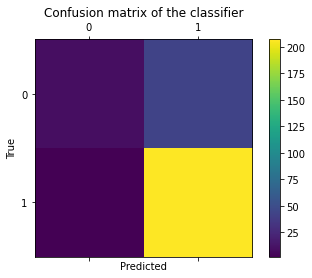

In [159]:
#confusion_matrix(true_classes, y_class)

labels = [0, 1]
cm = confusion_matrix(true_classes, y_class, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [160]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
#y_pred_keras = keras_model.predict(X_test).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, y_class)

auc_keras = auc(fpr_keras, tpr_keras)


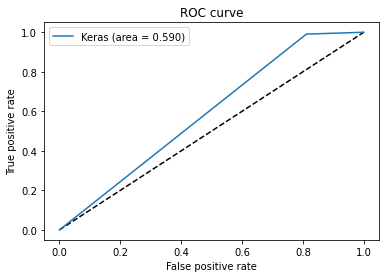

In [161]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# PART 7: NEXT STEPS

### More Data
Clearly our results are not where I want them to be yet, however this model does show promise as it does perform better than random guessing.  With only a couple hundred samples to train on, the data is insufficient to learn enough features to be able to generalize to new data.

### GPU Processing
GPUs can process CNNs magnitudes faster than the CPU.  The CPU worked fine for this relatively small dataset, but in the production environment with hundreds of thousands of images, I will need to take advantage of the GPUs processing power.  It will also allow me to test out larger training datasets and more data augmentation.

### Implement model in production environmet.
This will require the support of my IT department, since accessing the images on the backend requires special permissions. We are currently working on transitioning our backend storage of our images to BOX, which we can then also take advantage of AZURE computing power.

### Expand classifer to detect other document types
This classifer was focused around identify the FAA/EASA CERT form. The other 2 critical items I need to identify are the airline trace document and None Incident (NIS) form.